## BPC Broadband Spatial Visualization Tool

Due to memory limits, it makes sense to do states (or individual counties/blocks/etc) one my one, potentially merging for final visualization nationwide. I will start here with Santa Cruz county, as it has a nice mix of urban and rural blockgroups varying in size. 

### Step 1: obtain the FCC ISP form 477 data for a given census-designated area.

In [337]:
import pandas as pd
from sodapy import Socrata
import time
import geopandas as gpd
import numpy as np
import gc

def fcc_477_by_counties(county_geoids, verbose = False, chunk_size = 3000):
    '''
    Used to collect FCC 477 data and prepare it for analysis, using a list 
    of county geoid's as input.
    '''
    client = Socrata("opendata.fcc.gov", '9YvDmXxXdjHjkniU4OqfBNYAr', timeout=30)

    # https://opendata.fcc.gov/Wireline/Fixed-Broadband-Deployment-Data-Jun-2019-Status-V2/c67e-jknh
    # June 2019 FCC form 477 data, the last dataset where contractual downspeed is reported
    fcc_df = pd.DataFrame()
    for county_geoid in county_geoids:
        n_fetched = 0
        #python short-curcuit won't notice the lack of results on the first iteration
        while n_fetched % chunk_size == 0 or len(results) != 0:
            if verbose:
                print('number of records fetched: ' + str(n_fetched))
            try:
                results = client.get("c67e-jknh",
                                    where="starts_with(blockcode, '{}')".format(county_geoid),
                                    limit = chunk_size,
                                    offset = n_fetched)
                results_df = pd.DataFrame.from_records(results)
                fcc_df = pd.concat([fcc_df, results_df], axis = 'rows')
                n_fetched += len(results_df)
            except:
                if verbose:
                    print('timeout exception, trying again in 5 seconds')
                time.sleep(5)

    #found later - duplicates in the data, exact row copies. we will drop exact dupes.
    fcc_df = fcc_df.drop_duplicates()
    
    #trim to just interesting features
    fcc_df = fcc_df.loc[:,['blockcode', 'provider_id', 'techcode', 'business', 'consumer', 'maxaddown', 'maxadup', 'maxcirdown', 'maxcirup']]
    fcc_df.rename(columns = {'blockcode':'GEOID10'}, inplace = True)
    
    #convert speeds to float
    fcc_df.loc[:,['maxcirdown', 'maxcirup', 'maxadup','maxaddown']] = fcc_df.loc[:,['maxcirdown', 'maxcirup', 'maxadup','maxaddown']].applymap(float)
    
    #define our levels of access and factorize
    fcc_df.loc[:, 'access_level'] = np.select(
        [(fcc_df['maxcirdown'] >= 1000.0) & (fcc_df['maxcirup'] >= 1000.0) & (fcc_df['consumer'] == '1'),
        (fcc_df['maxcirdown'] >= 100.0) & (fcc_df['maxcirup'] >= 12.0) & (fcc_df['consumer'] == '1'),
        (fcc_df['maxcirdown'] >= 25.0) & (fcc_df['maxcirup'] >= 3.0) & (fcc_df['consumer'] == '1')],
        ['1000/1000 (Fiber)',
        '100/12 (BPC Access)',
        '25/3 (FCC Access)'],
        default = '<25/3 (Underserved)')
    fcc_df.loc[:,'access_level'] = pd.Categorical(
        fcc_df['access_level'],
        categories=['<25/3 (Underserved)','25/3 (FCC Access)','100/12 (BPC Access)','1000/1000 (Fiber)'],ordered=True)
    del results_df
    del results
    # del boundaries
    gc.collect()
    return fcc_df

#to test - santa cruz county, CA
# fcc_df = fcc_477_by_counties(['06087'], verbose = True)

In [338]:
#example santa cruz data
# fcc_df.head()

More detailed info can be found in the `references` folder, but the most important features in the FCC data are:

* `blockcode` - which we will use to join the FCC data to the smallest census area we have (blocks)
* `provider_id` - FCC id number for a unique ISP (since we don't particularly care about _who_ provides which services at this point, we will keep this provider id for sanity checking but drop other name fields)
* `techcode` - integer representing the kind of service provided -
    - 10=Asymetrical xDSL 
    - 11=ADSL2
    - 12=VDSL
    - 20=Symetrical xDSL
    - 30=Other Copper Wireline
    - 40=Cable Modem
    - 41=Cable Modem-DOCSIS1,1.1, and 2.0
    - 42=Cable Modem-DOCSIS 3.0
    - 43=Cable Modem-DOCSIS 3.1
    - 50=Optical Carrier/Fiber to the End User
    - 60=Satellite
    - 70=Terrestrial Fixed Wireless
    - 90=Electric Power Line
    - 0=All Other
* `business`/`consumer` - dummy variables indicating whether ISP services residences and/or business/government in the block. Note that this doesn't mean they necessarily _do_ provide the service, just that it is offered. 
* `maxaddown`/`maxadup` - advertised maximum up and downspeed.
* `maxcirdown`/`maxcirup` - contractual maximum up and downspeed.


### Step 2: Get the geometry for the relevant census blocks

For block-level geometry, we can only get the tiger data state by state from the below census website. In the future, if this workflow is to be production-level for any census designated area, we should set it up to download a state-level shapefile if needed, and then store to a filesystem cache (geodatabase or just directory of shapefiles) so that we don't redownload them if we don't need to. 

More detailed info can be found in the `references` folder, but the most important features in the TIGER data are:

* `GEOID10` - census block code we will use to join against FCC data
* `MTFCC10` - 'Feature Class Code' from census, designates the kind of land use for a given block
* `UR10` - Urban or Rural Classification
* `UACE10` - ID of urban area (can be joined with `references/ua_list_all.xls`) to get city/township names
* `UATYPE` - Indicator for urban areas with 50k or more people (U) and clusters with 2.5k to 50k (C)
* `ALAND10`/`AWATER10` - sqaure meters of land and water in the census block 
* `GEOMETRY` - index and polygon of census block to use for mapping

### Step 2: Set up block-level census data pull for given counties

In [339]:
import censusdata

def flatten_censusgeo_hierarchy(geo_params):
    return ''.join([str(digits) for (level, digits) in geo_params])

def dec_by_counties(county_geoids):
    '''
    Used to collect FCC 477 data and prepare it for analysis, using a list 
    of county geoid's as input.
    '''
    dec_combined = pd.DataFrame()
    for county_geoid in county_geoids:
        state_code = county_geoid[:2]
        county_code = county_geoid[2:]
        dec = censusdata.download("sf1", 2010, censusdata.censusgeo(
            [("state", state_code), ("county", county_code),('block', "*")]),
            ['P003001', #N Race (TOTAL)
            'P003002', #N White Alone
            'P003003', #N Black and African American Alone
            'P003004', #N American Indian and Alaska Native Alone
            'P003005', #N Asian Alone
            'P003006', #N Native Hawaiian and Other Pacific Islander Alone
            'P003007', #N Other Race Alone
            'P003008', #N Two or More Races
            'P004001', #N Hispanic or Latino (TOTAL)
            'P004002', #N Not Hispanic or Latino
            'P004003', #N Hispanic or Latino
            'H011001', #N Housing Status (TOTAL)
            'H011002', #N Owned with Mortgage
            'H011003', #N Owned Free and Clear
            'H011004']) #N Renting
        dec.loc[:,'GEOID10'] = pd.Series(dec.index)\
            .apply(lambda x: flatten_censusgeo_hierarchy(x.params())).to_numpy()    
        dec_combined = pd.concat([dec_combined, dec], axis = 'rows', ignore_index=True)

    dec_combined.rename(columns = {'P003001' : 'N_RaceTotal', #N Race (TOTAL)
        'P003002': 'N_White', #N White Alone
        'P003003': 'N_BlackAfAmer', #N Black and African American Alone
        'P003004': 'N_AmerIndian',#N American Indian and Alaska Native Alone
        'P003005': 'N_Asian',#N Asian Alone
        'P003006': 'N_HawaiianPacific',#N Native Hawaiian and Other Pacific Islander Alone
        'P003007': 'N_Other', #N Other Race Alone
        'P003008': 'N_TwoOrMore', #N Two or More Races
        'P004001': 'N_HispanicTotal', #N Hispanic or Latino (TOTAL)
        'P004002': 'N_NotHispanic', #N Not Hispanic or Latino
        'P004003': 'N_Hispanic', #N Hispanic or Latino
        'H011001': 'N_HousingTotal',#N Housing Status (TOTAL)
        'H011002': 'N_OwnedMortgage',#N Owned with Mortgage
        'H011003': 'N_OwnedFree', #N Owned Free and Clear
        'H011004': 'N_Renting'}, inplace=True)
    
    
    dec_combined.reset_index(drop=True, inplace=True)
    return dec_combined


### Step 3: Get Microsoft county level data

In [340]:
microsoft_usage = pd.read_csv('data/microsoft_usage_data/broadband_data_2019November.csv')
#need to pad microsoft county data with prepended zeros
microsoft_usage.loc[:,'COUNTY ID'] = microsoft_usage.loc[:,'COUNTY ID'].apply(lambda id: str(id).zfill(5))
microsoft_usage.head()

,ST,COUNTY ID,COUNTY NAME,BROADBAND AVAILABILITY PER FCC,BROADBAND USAGE
0,AL,01001,Autauga County,0.81,0.28
1,AL,01003,Baldwin County,0.88,0.30
2,AL,01005,Barbour County,0.59,0.18
3,AL,01007,Bibb County,0.29,0.07
4,AL,01009,Blount County,0.69,0.09


### Step 4: Get county-level shapefiles for mapping congressional districts

In [341]:
county_congress = pd.read_csv('data/congress_to_county/natl_cocd_delim.csv')
#same as above, need to pad counties and states to get 5-digit county id
county_congress.loc[:,'County'] = county_congress.loc[:,'County'].apply(lambda id: str(id).zfill(3))
county_congress.loc[:,'State'] = county_congress.loc[:,'State'].apply(lambda id: str(id).zfill(2))
county_congress.loc[:,'GEOID'] = county_congress.apply(lambda row: row.State + row.County, axis = 1)
county_congress.set_index('GEOID', inplace=True)
county_congress.head()

,State,County,Congressional District
GEOID,,,
01001,01,001,2
01003,01,003,1
01005,01,005,2
01007,01,007,6
01009,01,009,4


In [342]:
county_geo = gpd.read_file('data/county_shp/cb_2019_us_county_500k.shp')
county_geo.set_index('GEOID', inplace=True)
county_geo.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
GEOID,,,,,,,,,
48081,48,081,01383826,0500000US48081,Coke,06,2361153195,42331832,"POLYGON ((-100.82497 31.74941, -100.82415 31.8..."
48273,48,273,01383922,0500000US48273,Kleberg,06,2282572445,541041659,"MULTIPOLYGON (((-97.31780 27.49456, -97.31590 ..."
48203,48,203,01383887,0500000US48203,Harrison,06,2331138836,40651525,"POLYGON ((-94.70215 32.45618, -94.70197 32.467..."
48223,48,223,01383897,0500000US48223,Hopkins,06,1987629163,65639829,"POLYGON ((-95.86333 33.04989, -95.86302 33.065..."
48033,48,033,01383802,0500000US48033,Borden,06,2324366073,22297606,"POLYGON ((-101.69128 32.96184, -101.55743 32.9..."


In [343]:
county_geo = county_geo.join(county_congress, how = 'left')
# county_geo.reset_index(inplace=True)
# county_geo.head()

<AxesSubplot:>

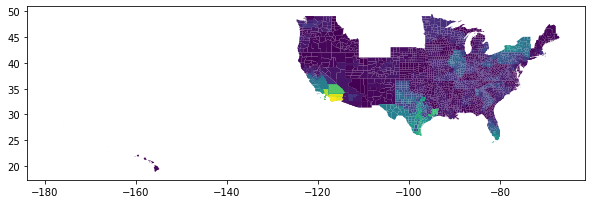

In [344]:
county_geo.plot('Congressional District', figsize = (10,10), legend = False) #We are missing entire
#states for some reason... will need to investigate this later, but shouldn't be 
#an issue for our current test case

### Step 4: Aggregate by county and join it all together

At this point we have:
* FCC data (fcc_df) from Form 477 data aggregated to the block level
* decennial census data aggregated to the block level

We want to summarize these things at the county level, so that we can join:
* microsoft _actual_ broadband usage data, aggregated to the block level
* (potentially) M-lab user statistics, aggegated to the county level
* county spatial geometry for mapping

When all is said and done, we want to visualize congressional districts.

In [345]:
#fcc spatial data:
tst_counties = pd.unique(county_geo[(county_geo['State'] == '06') & (county_geo['Congressional District'] == 18)].index)
# fcc_df.set_index('GEOID10', inplace=True)
# fcc_df.head()
# fcc_df = fcc_477_by_counties(tst_counties, verbose = True)
fcc_df = pd.read_pickle('data/fcc477_SC.pkl')
fcc_df.head()

,GEOID10,provider_id,techcode,business,consumer,maxaddown,maxadup,maxcirdown,maxcirup,access_level
0,060816059003007,58057,11,0,1,18.0,0.768,0.0,0.0,<25/3 (Underserved)
1,060816115002012,53601,60,1,1,2.0,1.3,0.0,0.0,<25/3 (Underserved)
2,060816120001007,58057,12,0,1,50.0,10.0,0.0,0.0,<25/3 (Underserved)
3,060816135011028,61431,60,1,0,0.0,0.0,0.0,0.0,<25/3 (Underserved)
4,060816119006007,50820,60,1,1,100.0,3.0,0.0,0.0,<25/3 (Underserved)


In [346]:
fcc_df.set_index('GEOID10', inplace=True)
# fcc_df.to_pickle('data/fcc477_SC.pkl')

In [347]:
best_access = fcc_df.loc[:,'access_level'].groupby('GEOID10').value_counts()
access_count = best_access.apply(pd.Series)\
        .reset_index()\
        .pivot(index = 'GEOID10', columns='access_level', values=0)\
        .fillna(0)
#For now - need to make sure the columns propogate downward to lower levels of 
#access (fiber should effectively mean every previous level of access is reached
#for that ISP in that block). There should be a way to handle this considering 
#access_level is coded as a factor w/ levels, but this works for now.
for i in range(0, len(access_count.columns) - 1):
        access_count.iloc[:,i] = \
            access_count.iloc[:,i] + access_count.iloc[:,i+1:].sum(axis = 'columns')
access_count.head()

access_level,<25/3 (Underserved),25/3 (FCC Access),100/12 (BPC Access),1000/1000 (Fiber)
GEOID10,,,,
060816001001000,1.0,0.0,0.0,0.0
060816001001001,2.0,0.0,0.0,0.0
060816001001002,6.0,1.0,1.0,0.0
060816001001003,6.0,1.0,1.0,0.0
060816001001004,5.0,0.0,0.0,0.0


In [348]:
fcc_df.sort_index().head(20) #above looks correct

,provider_id,techcode,business,consumer,maxaddown,maxadup,maxcirdown,maxcirup,access_level
GEOID10,,,,,,,,,
060816001001000,52245,11,1,1,40.0,3.0,0.0,0.0,<25/3 (Underserved)
060816001001001,53153,60,1,1,25.0,3.0,0.0,0.0,<25/3 (Underserved)
060816001001001,53601,60,1,1,2.0,1.3,0.0,0.0,<25/3 (Underserved)
060816001001002,53601,60,1,1,2.0,1.3,0.0,0.0,<25/3 (Underserved)
060816001001002,52245,11,1,1,40.0,3.0,0.0,0.0,<25/3 (Underserved)
060816001001002,52245,30,1,0,0.0,0.0,100.0,100.0,<25/3 (Underserved)
060816001001002,54368,70,1,1,100.0,100.0,100.0,100.0,100/12 (BPC Access)
060816001001002,61431,60,1,0,0.0,0.0,0.0,0.0,<25/3 (Underserved)
060816001001002,53153,60,1,1,25.0,3.0,0.0,0.0,<25/3 (Underserved)


In [349]:
#decennial census data
dec = dec_by_counties(tst_counties)
dec.set_index('GEOID10', inplace=True)
dec.head()


,N_RaceTotal,N_White,N_BlackAfAmer,N_AmerIndian,N_Asian,N_HawaiianPacific,N_Other,N_TwoOrMore,N_HispanicTotal,N_NotHispanic,N_Hispanic,N_HousingTotal,N_OwnedMortgage,N_OwnedFree,N_Renting
GEOID10,,,,,,,,,,,,,,,
060816001001058,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001063,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001069,6,6,0,0,0,0,0,0,6,1,5,6,6,0,0
060816001001059,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001061,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [350]:
block_data = access_count.join(dec, how='left')
block_data.head(30)

,<25/3 (Underserved),25/3 (FCC Access),100/12 (BPC Access),1000/1000 (Fiber),N_RaceTotal,N_White,N_BlackAfAmer,N_AmerIndian,N_Asian,N_HawaiianPacific,N_Other,N_TwoOrMore,N_HispanicTotal,N_NotHispanic,N_Hispanic,N_HousingTotal,N_OwnedMortgage,N_OwnedFree,N_Renting
GEOID10,,,,,,,,,,,,,,,,,,,
060816001001000,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001001,2.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001002,6.0,1.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001003,6.0,1.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001004,5.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001005,8.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001006,3.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001007,6.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
060816001001008,6.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [351]:
#first, need to parse out the county id to join the other data
block_data.loc[:,'GEOID'] = block_data.index.to_series().apply(lambda str: str[0:5])
pd.unique(block_data['GEOID']) #looks good

array(['06081', '06085', '06087'], dtype=object)

In [352]:
sum(block_data['N_RaceTotal'] == block_data['N_HispanicTotal'])

36641

In [353]:
sum(block_data['N_RaceTotal'] == block_data['N_HousingTotal']) #some blocks do not
#have housing demographic info but there appears to be no disagreement between the 
#demography metrics

35263

In [354]:
def calc_percentage_by_geoid(dec_df, col_tuples, access_condition = None):
    results_df = pd.DataFrame()
    for total_col, group_totals in col_tuples:
        if not access_condition:
            df_total = dec_df.loc[:, group_totals + [total_col, 'GEOID']].groupby('GEOID').sum()
        else:
            df_total = dec_df[dec_df['access_level'] >= access_condition]\
                .loc[:, group_totals + [group_totals, 'GEOID']].groupby('GEOID').sum()
        results_df = pd.concat([results_df, 
            df_total.loc[:,group_totals].div(df_total[total_col], axis = 'rows')],
            axis = 'columns')
        results_df.columns = results_df.columns.str.replace('N_','Pct_')
    return results_df

var_tups = [('N_HousingTotal', ['N_OwnedMortgage','N_OwnedFree','N_Renting']),
            ('N_RaceTotal', ['N_White', 'N_BlackAfAmer', 'N_AmerIndian', 'N_Asian',
                'N_HawaiianPacific', 'N_Other', 'N_TwoOrMore']),
            ('N_HispanicTotal', ['N_NotHispanic', 'N_Hispanic'])]
dempct_df = calc_percentage_by_geoid(block_data, var_tups)



In [355]:
dempct_df

,Pct_OwnedMortgage,Pct_OwnedFree,Pct_Renting,Pct_White,Pct_BlackAfAmer,Pct_AmerIndian,Pct_Asian,Pct_HawaiianPacific,Pct_Other,Pct_TwoOrMore,Pct_NotHispanic,Pct_Hispanic
GEOID,,,,,,,,,,,,
06081,0.502209,0.104491,0.393300,0.533869,0.028444,0.004602,0.247882,0.014361,0.117660,0.053181,0.745969,0.254031
06085,0.494133,0.097822,0.408045,0.469586,0.026060,0.007274,0.320213,0.003962,0.123936,0.048968,0.731023,0.268977
06087,0.463890,0.107218,0.428892,0.724928,0.010542,0.008587,0.042350,0.001330,0.165316,0.046947,0.679505,0.320495


After talking with Tom, we are going to focus on the Form 477 data in tandem with Microsoft data, to get a sense of counties with high priority. But, whenever demographics may be useful in the future, this decennial demographic setup should do the trick (joining by GEOID, in this case, county).

In [356]:
#most important thing is simply the number of people responded per census block...
#not finding much info on how to get this number, but we have an example aggregation
#from the city of chicago, so I will see if it agrees
# tst = dec_by_counties(['17031'])

In [357]:
# tst.head()
#agrees with https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Population-by-2010-Census-Block/5yjb-v3mj
#going to keep investigating whether this is correct, but we will use N_RaceTotal as our pop metric for now

### Step 5: Join MS data, and count number of people with certain levels of access by county

In [358]:
block_data = block_data.iloc[:,:5].rename(columns={"N_RaceTotal":'Population'})

In [359]:
block_data.loc[:,'GEOID'] = block_data.index.to_series().apply(lambda str: str[0:5])


In [360]:
block_data.head(30)

,<25/3 (Underserved),25/3 (FCC Access),100/12 (BPC Access),1000/1000 (Fiber),Population,GEOID
GEOID10,,,,,,
060816001001000,1.0,0.0,0.0,0.0,0,06081
060816001001001,2.0,0.0,0.0,0.0,0,06081
060816001001002,6.0,1.0,1.0,0.0,0,06081
060816001001003,6.0,1.0,1.0,0.0,0,06081
060816001001004,5.0,0.0,0.0,0.0,0,06081
060816001001005,8.0,1.0,1.0,1.0,0,06081
060816001001006,3.0,0.0,0.0,0.0,0,06081
060816001001007,6.0,1.0,1.0,1.0,0,06081
060816001001008,6.0,0.0,0.0,0.0,0,06081


In [361]:
sum_by_county = block_data.loc[:,['GEOID', 'Population']].groupby('GEOID').sum()

In [362]:
sum_by_county

,Population
GEOID,
06081,718322
06085,1781570
06087,262382


In [363]:
sum_fcc = block_data[block_data['25/3 (FCC Access)'] > 0].loc[:,['GEOID', 'Population']].groupby('GEOID').sum().rename(columns={'Population':
'N_25/3'})
sum_bpc = block_data[block_data['100/12 (BPC Access)'] > 0].loc[:,['GEOID', 'Population']].groupby('GEOID').sum().rename(columns={'Population':
'N_100/12'})
sum_fiber = block_data[block_data['1000/1000 (Fiber)'] > 0].loc[:,['GEOID', 'Population']].groupby('GEOID').sum().rename(columns={'Population':
'N_1000/1000'})

In [364]:
county_data = pd.concat([sum_by_county, sum_fcc, sum_bpc, sum_fiber], axis = 'columns')

In [365]:
county_data.reset_index(inplace=True)
county_data = calc_percentage_by_geoid(county_data, [('Population', ['N_25/3', 'N_100/12', 'N_1000/1000'])])

In [366]:
county_data = county_data.applymap(lambda x: 1-x)
county_data.columns = county_data.columns.str.replace('Pct_', 'PctLacking_')

In [367]:
microsoft_usage.rename(columns={'COUNTY ID':'GEOID'}, inplace=True)
microsoft_usage.set_index('GEOID', inplace=True)

In [368]:
microsoft_usage.columns

Index(['ST', 'COUNTY NAME', ' BROADBAND AVAILABILITY PER FCC ',
       ' BROADBAND USAGE '],
      dtype='object')

In [369]:
microsoft_usage.rename(columns={' BROADBAND USAGE ': 'BROADBAND USAGE'}, inplace = True)
microsoft_usage.loc[:,'PctNotAchieving_25/3'] = microsoft_usage.loc[:,'BROADBAND USAGE'].replace(' -   ', np.nan).apply(lambda x: 1 - float(x))

In [370]:
microsoft_usage.columns

Index(['ST', 'COUNTY NAME', ' BROADBAND AVAILABILITY PER FCC ',
       'BROADBAND USAGE', 'PctNotAchieving_25/3'],
      dtype='object')

In [371]:
county_data = county_data.join(microsoft_usage.loc[:,['PctNotAchieving_25/3']], how = 'left')

In [372]:
#lastly, join with geometry
county_data = county_data.join(county_geo.loc[:,['NAME','geometry']], how = 'left')

In [373]:
county_data.head()

,PctLacking_25/3,PctLacking_100/12,PctLacking_1000/1000,PctNotAchieving_25/3,NAME,geometry
GEOID,,,,,,
06081,0.299299,0.377134,0.895554,0.38,San Mateo,"POLYGON ((-122.52085 37.59418, -122.51533 37.5..."
06081,0.299299,0.377134,0.895554,0.38,San Mateo,"POLYGON ((-122.52085 37.59418, -122.51533 37.5..."
06085,0.360621,0.405072,0.989785,0.07,Santa Clara,"POLYGON ((-122.20265 37.36305, -122.20163 37.3..."
06085,0.360621,0.405072,0.989785,0.07,Santa Clara,"POLYGON ((-122.20265 37.36305, -122.20163 37.3..."
06085,0.360621,0.405072,0.989785,0.07,Santa Clara,"POLYGON ((-122.20265 37.36305, -122.20163 37.3..."


In [374]:
county_data.describe() #BROADBAND USAGE Missing, must be a str

,PctLacking_25/3,PctLacking_100/12,PctLacking_1000/1000,PctNotAchieving_25/3
count,8.000000,8.000000,8.000000,8.000000
mean,0.319095,0.427540,0.964205,0.240000
std,0.047336,0.060095,0.042519,0.183147
min,0.255837,0.377134,0.895554,0.070000
25%,0.288433,0.398088,0.960159,0.070000
50%,0.329960,0.405072,0.985740,0.225000
75%,0.360621,0.434524,0.989785,0.395000
max,0.360621,0.522879,0.989785,0.440000


In [376]:
county_data = gpd.GeoDataFrame(county_data.drop_duplicates())
county_data = county_data.to_crs(epsg = 3857)

In [377]:
#get lims from what we care about right now, the congressional district
buffer = 10000
bboxes = county_data[~pd.isna(county_data['PctLacking_25/3'])].geometry.bounds
xrange_ = min(bboxes['minx']) - buffer, max(bboxes['maxx']) + buffer
yrange_ = min(bboxes['miny']) - buffer, max(bboxes['maxy']) + buffer

In [378]:
def map_congressional_district(base_geo, var_geo, variable, title, path_out = None):

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    ax.set_ylim(yrange_)
    ax.set_xlim(xrange_)

    base_geo = base_geo.to_crs(var_geo.crs)

    base_geo.plot(ax = ax, figsize = (10,10), color = 'grey')
    var_geo.plot(variable,
                figsize = (10,10),
                legend=True,
                ax = ax,
                vmin = 0,
                vmax = 1,
                cmap = 'OrRd')

    for idx, row in var_geo.iterrows():
        if not pd.isna(row[variable]):
            rep_point = row['geometry'].representative_point().coords[:][0]
            plt.annotate(text=row['NAME'] + '\n{:.1%}'.format(row[variable]),
                        xy=rep_point,
                        horizontalalignment='center',
                        color='black')

    plt.figure(figsize=(10,10))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.suptitle(title)
    if path_out:
        plt.savefig(path_out)
    return fig, ax

In [379]:
county_data.head()

,PctLacking_25/3,PctLacking_100/12,PctLacking_1000/1000,PctNotAchieving_25/3,NAME,geometry
GEOID,,,,,,
06081,0.299299,0.377134,0.895554,0.38,San Mateo,"POLYGON ((-13638959.026 4522254.629, -13638343..."
06085,0.360621,0.405072,0.989785,0.07,Santa Clara,"POLYGON ((-13603537.318 4489832.364, -13603423..."
06087,0.255837,0.522879,0.981695,0.44,Santa Cruz,"POLYGON ((-13616342.356 4465196.911, -13613102..."


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

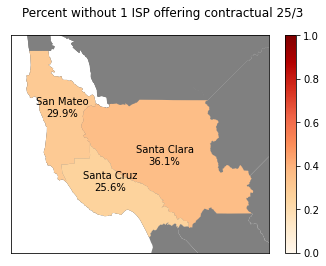

<Figure size 720x720 with 0 Axes>

In [380]:
map_congressional_district(county_geo, county_data, 'PctLacking_25/3', 'Percent of constituents without \n1 ISP offering contractual 25/3')

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

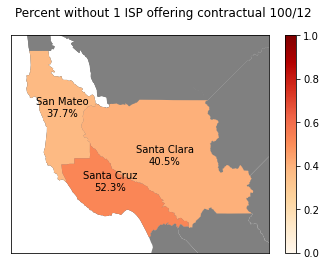

<Figure size 720x720 with 0 Axes>

In [381]:
map_congressional_district(county_geo, county_data, 'PctLacking_100/12', 'Percent of constituents without \n 1 ISP offering contractual 100/12')

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

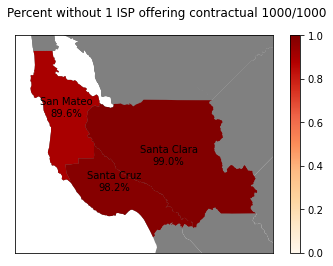

<Figure size 720x720 with 0 Axes>

In [382]:
map_congressional_district(county_geo, county_data, 'PctLacking_1000/1000', 'Percent of constituents without \n 1 ISP offering contractual 1000/1000')

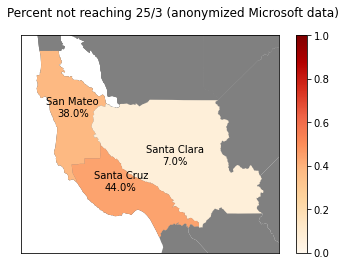

<Figure size 720x720 with 0 Axes>

In [384]:
ms = map_congressional_district(county_geo, county_data, 'PctNotAchieving_25/3', 'Percent of constituents not reaching 25/3 (anonymized Microsoft data)')

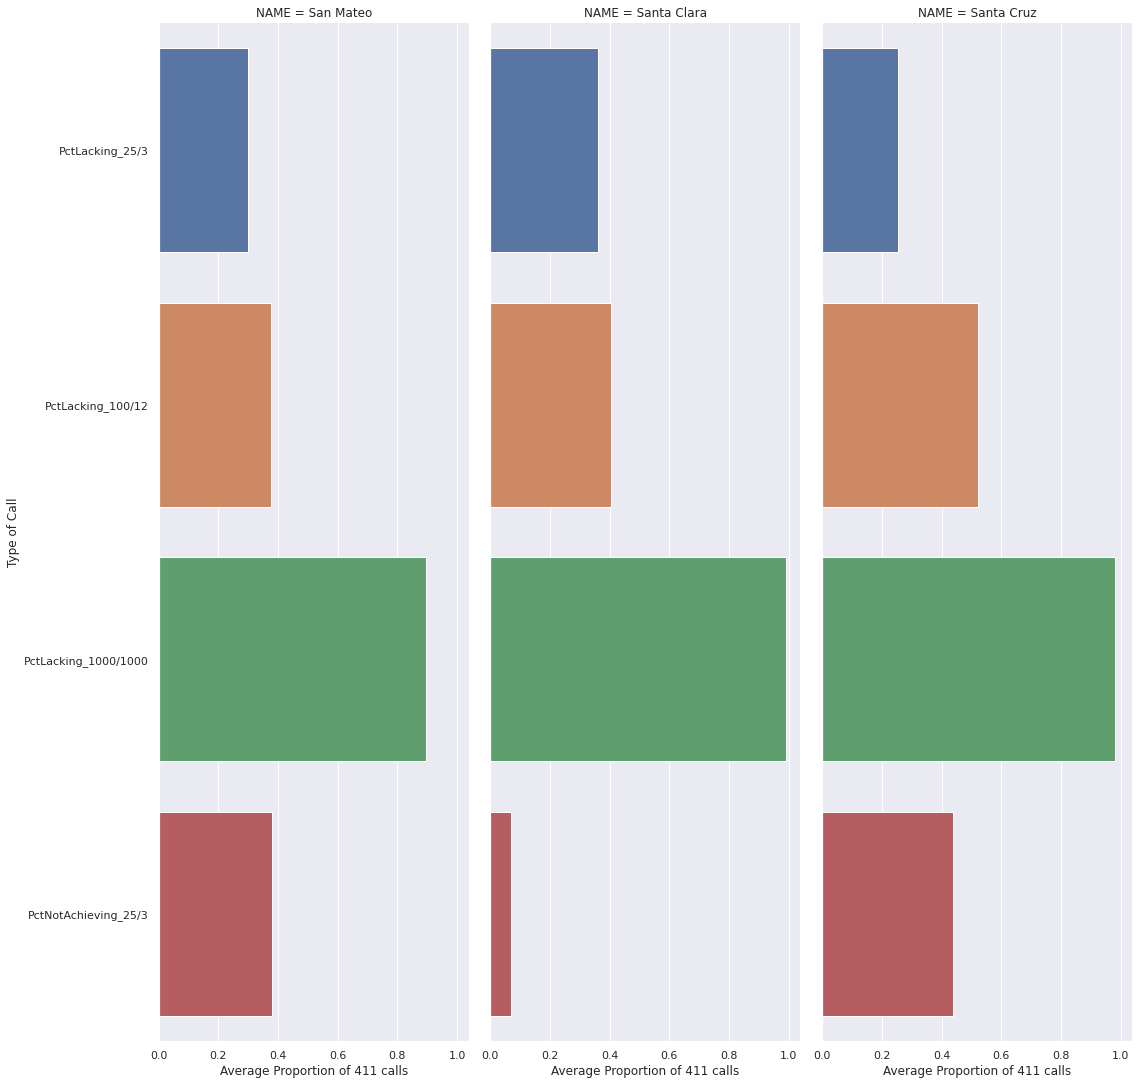

In [395]:
import seaborn as sns
county_long = county_data.drop(columns='geometry').set_index('NAME').melt(ignore_index = False).reset_index()
sns.set(rc={"figure.figsize":(3, 12)})
clust_compare = sns.catplot(data = county_long,
                            x = 'value',
                            y = 'variable',
                            col = 'NAME',
                            kind = 'bar',
                            col_wrap = 3, 
                            height = 15,
                            aspect= .35)
clust_compare.set_axis_labels('Percent of Population', 'Metric')
clust_compare